In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/bangkit-2020-dps04-us-test001/aksara-jawa-v5.zip \
    -O /tmp/aksara-jawa-v5.zip

--2020-06-15 09:46:54--  https://storage.googleapis.com/bangkit-2020-dps04-us-test001/aksara-jawa-v5.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.76.128, 2a00:1450:400c:c00::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.76.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 194968769 (186M) [application/zip]
Saving to: ‘/tmp/aksara-jawa-v5.zip’

/tmp/aksara-jawa-v5 100%[===================>] 185.94M   186MB/s    in 1.0s    

2020-06-15 09:46:56 (186 MB/s) - ‘/tmp/aksara-jawa-v5.zip’ saved [194968769/194968769]



In [0]:
#Unzip files dataset
import os
import zipfile

local_zip = '/tmp/aksara-jawa-v5.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/aksara-jawa/')
zip_ref.close()

In [0]:
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
import time

In [0]:
#Hyperparameter
HEIGHT = 64
WIDTH = 64

BATCH_SIZE=8
NUM_CLASSES = 20
EPOCHS = 40

### Setup dataset Generator

Using TensorFlow backend.


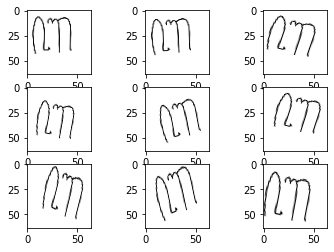

In [5]:
# example of image augmentation
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
# load the image
img = load_img('/tmp/aksara-jawa/newdatasetaug/newtesting/ba/ba17.mine3.b.png', target_size=(HEIGHT, WIDTH))
# convert to numpy array
data = img_to_array(img)
# expand dimension to one sample
samples = expand_dims(data, 0)

# create image data augmentation generator
# datagen = ImageDataGenerator(height_shift_range=0.5)
datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    rotation_range=20,
    fill_mode='nearest')


# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
pyplot.show()

In [6]:
TRAINING_DIR = "/tmp/aksara-jawa/newdatasetaug/newtraining/"
training_datagen = ImageDataGenerator(
    validation_split=.2,
    rescale = 1./255,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    rotation_range=20,
    fill_mode='nearest')

TEST_DIR = "/tmp/aksara-jawa/newdatasetaug/newtesting/"
test_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    subset='training',
    target_size=(HEIGHT, WIDTH),
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

validation_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    subset='validation',
    target_size=(HEIGHT, WIDTH),
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(HEIGHT, WIDTH),
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 1161 images belonging to 20 classes.
Found 280 images belonging to 20 classes.
Found 839 images belonging to 20 classes.


### Create Model

In [7]:
model = tf.keras.models.Sequential([
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), input_shape=(HEIGHT, WIDTH, 3)),
    tf.keras.layers.LeakyReLU(alpha=.1),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(32, (3,3)),
    tf.keras.layers.LeakyReLU(alpha=.1),
    tf.keras.layers.MaxPooling2D(2,2), 

    tf.keras.layers.Conv2D(64, (3,3)), 
    tf.keras.layers.LeakyReLU(alpha=.1),
    tf.keras.layers.MaxPooling2D(2,2),
    
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    
    # 64 neuron hidden layer
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 16)        448       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 62, 62, 16)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 32)        4640      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 29, 29, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        1

In [0]:
from tensorflow.keras.callbacks import ModelCheckpoint 

checkpointer = ModelCheckpoint(filepath='weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

In [9]:
model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

time_start = time.time()#measure training time
history = model.fit(train_generator, epochs=EPOCHS, validation_data = validation_generator, verbose = 1, callbacks=[checkpointer])
time_end = time.time()

Epoch 1/40
146/146 [==============================] - ETA: 0s - loss: 3.0037 - accuracy: 0.0491
Epoch 00001: val_loss improved from inf to 2.97771, saving model to weights.best.from_scratch.hdf5
146/146 [==============================] - 24s 165ms/step - loss: 3.0037 - accuracy: 0.0491 - val_loss: 2.9777 - val_accuracy: 0.0536
Epoch 2/40
146/146 [==============================] - ETA: 0s - loss: 2.8806 - accuracy: 0.1120
Epoch 00002: val_loss improved from 2.97771 to 2.75708, saving model to weights.best.from_scratch.hdf5
146/146 [==============================] - 24s 164ms/step - loss: 2.8806 - accuracy: 0.1120 - val_loss: 2.7571 - val_accuracy: 0.1607
Epoch 3/40
146/146 [==============================] - ETA: 0s - loss: 2.6511 - accuracy: 0.1766
Epoch 00003: val_loss improved from 2.75708 to 2.48327, saving model to weights.best.from_scratch.hdf5
146/146 [==============================] - 24s 163ms/step - loss: 2.6511 - accuracy: 0.1766 - val_loss: 2.4833 - val_accuracy: 0.3107
Epoch

In [10]:
elapsed_time = time_end - time_start
print("Elapsed time (s): % 5.2f" %(elapsed_time)) 

Elapsed time (s):  968.29


In [11]:
model.load_weights('weights.best.from_scratch.hdf5') #load weight terbaik

# model.save("aksara.h5")

# Melakukan test
model.evaluate(test_generator)

105/105 [==============================] - 13s 120ms/step - loss: 0.1552 - accuracy: 0.9726


[0.1551855206489563, 0.9725863933563232]

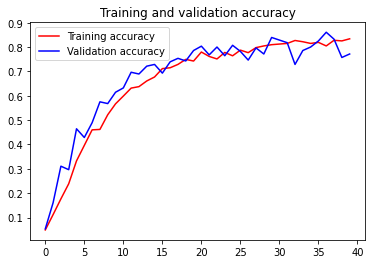

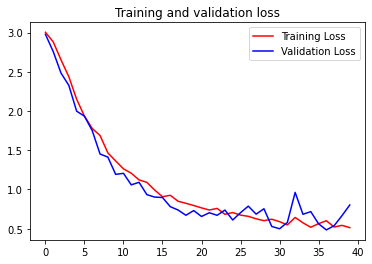

In [12]:
# Plot kurva akurasi
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()


plt.show()

In [14]:
#lakukan test dengan gambar baru
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
    # predicting images
    path = fn
    img = image.load_img(path, target_size=(HEIGHT, WIDTH))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)
    print(fn)
    print(classes)
    
    predicted_class_indices=np.argmax(classes,axis=1)
    labels = (train_generator.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    predictions = [labels[k] for k in predicted_class_indices]
    print(predictions)



Saving ba49.mine2.png to ba49.mine2 (1).png
Saving nga220.pred.png to nga220.pred (1).png
Saving ra164.pred.png to ra164.pred (1).png
ba49.mine2.png
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
['ba']
nga220.pred.png
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
['nga']
ra164.pred.png
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
['ra']


### Export Model

In [0]:
# export model
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")

In [16]:
#export model pb
model_version = "1"
model_name = "aksara-model"
model_path = os.path.join(model_name, model_version)
tf.saved_model.save(model, model_path)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: aksara-model/1/assets


In [17]:
! zip -r aksara-model.zip aksara-model

  adding: aksara-model/ (stored 0%)
  adding: aksara-model/1/ (stored 0%)
  adding: aksara-model/1/saved_model.pb (deflated 88%)
  adding: aksara-model/1/assets/ (stored 0%)
  adding: aksara-model/1/variables/ (stored 0%)
  adding: aksara-model/1/variables/variables.index (deflated 66%)
  adding: aksara-model/1/variables/variables.data-00000-of-00002 (deflated 79%)
  adding: aksara-model/1/variables/variables.data-00001-of-00002 (deflated 7%)


#### Visualize Convolution

In [0]:
import os
train_ba_dir = os.path.join(TRAINING_DIR, 'ba')
train_ca_dir = os.path.join(TRAINING_DIR, 'ca')

train_ba_fnames = os.listdir( train_ba_dir )
train_ca_fnames = os.listdir( train_ca_dir )


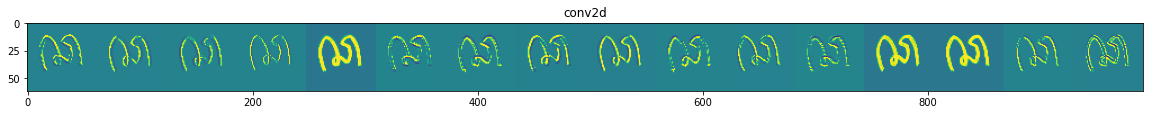

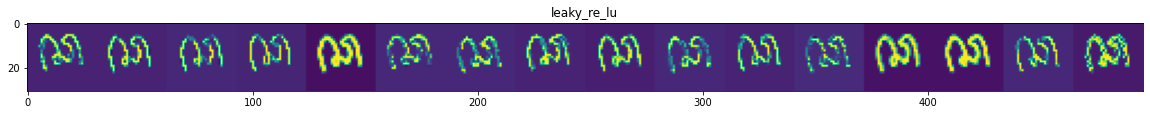

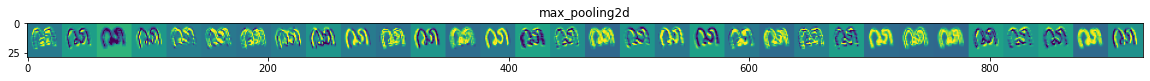

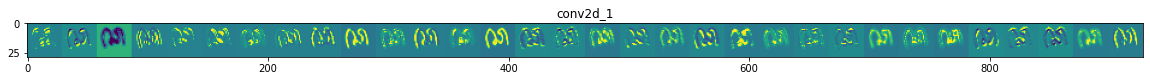

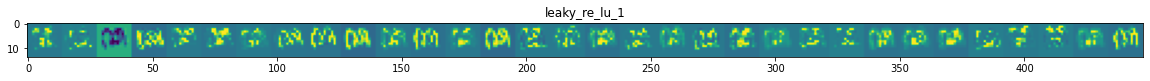

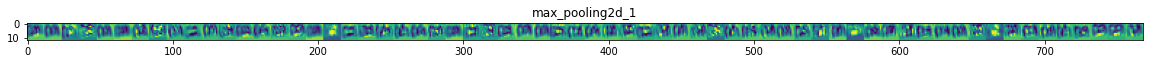

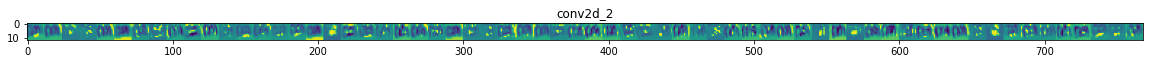

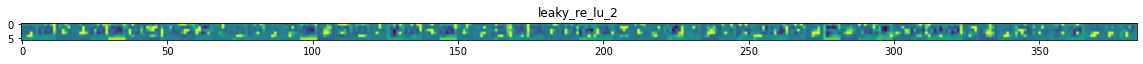

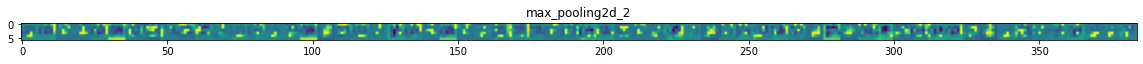

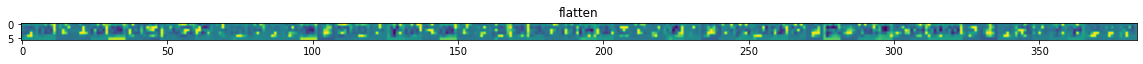

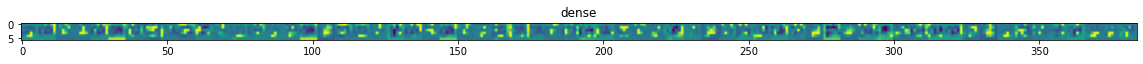

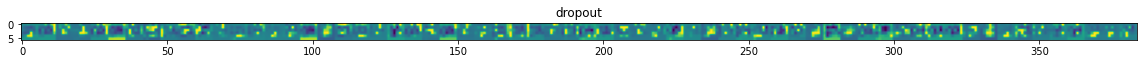

In [19]:
import numpy as np
import random
from   tensorflow.keras.preprocessing.image import img_to_array, load_img

successive_outputs = [layer.output for layer in model.layers[1:]]

visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Let's prepare a random input image from the training set.
ba_img_files = [os.path.join(train_ba_dir, f) for f in train_ba_fnames]
ca_img_files = [os.path.join(train_ca_dir, f) for f in train_ca_fnames]

img_path = random.choice(ba_img_files + ca_img_files)
img = load_img(img_path, target_size=(HEIGHT, WIDTH))  # this is a PIL image

x   = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255.0

successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]


# -----------------------------------------------------------------------
# Now let's display our representations
# -----------------------------------------------------------------------
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  
    if len(feature_map.shape) == 4:

        #-------------------------------------------
        # Just do this for the conv / maxpool layers, not the fully-connected layers
        #-------------------------------------------
        n_features = feature_map.shape[-1]  # number of features in the feature map
        size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)

        # We will tile our images in this matrix
        display_grid = np.zeros((size, size * n_features))

        #-------------------------------------------------
        # Postprocess the feature to be visually palatable
        #-------------------------------------------------
        for i in range(n_features):
            x  = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std ()
            x *=  64
            x += 128
            x  = np.clip(x, 0, 255).astype('uint8')
            display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    #-----------------
    # Display the grid
    #-----------------

    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 